## CS 5010 - Semester Project
## Landon Blakely, Anvar Sarbanov, Claire Setser, Hanim Song
## ldb3mj, as5da, cas3hp, hs4cf

# Introduction 
 
From 2010 through 2015, an average of 16 hate crimes were reported per day according to data from the FBI. This daily average rose to 90 per day in the 10 days following the 2016 US presidential election as reported to the Southern Poverty Law Center. The goal of this project is to analyze potential factors that may lead to higher rates of hate crimes. In addition to the organized data from 2010 through 2015, we webscraped 2018 hate crime data from the FBI website to look into the hate crime categories. We also compared the 2018 hate crime trend to 2010-2015.


# About the Data 
 
Our group decided to look at the hate crime dataset from fivethirtyeight, that has gathered hate crime data from the FBI (2010-2015) and SPLC (Southern Poverty Law Center, 2016) and organized those hate crimes by various factors. Our group decided to look into five variables against the FBI and SPLC hate crime, and the five variables are states, Gini Index, median household income, share voters who voted for Trump, and unemployed population. It should be noted that the hate crime data provided by FBI and SPLC are limited in that FBI doesn’t track hate crimes systematically (agencies report to FBI voluntarily), and that SPLC uses media accounts and people's self-reports to assess the hate crime situation. 
 
Hate crime data from the FBI for 2018 was gathered by state to include the total number of hate crime incidents and category of hate crimes: Race/Ethnicity/Ancestry, Religion, Sexual Orientation/Gender, Disability, and Other. Data from the US Census was also gathered to create a similar analysis done with the 2010-2015 data. The variables include School system expenditure, median household income, share population white, gini index, and share population of high school graduates(age 18-24). 


In [1]:
#import libraries
import pandas as pd
from us import states
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re
import requests
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import statsmodels.api as sm # used for linear regressions
import statsmodels.formula.api as smf
from mpl_toolkits import mplot3d
%matplotlib notebook

# 2010-2015 Data

In [2]:
get_ipython().run_line_magic('matplotlib', 'inline')
# Read the csv file:
url = 'https://raw.githubusercontent.com/hs4cf/CS-Python-Project/master/hate_crimes.csv'
data = pd.read_csv(url, error_bad_lines=False)
data #disply 2010-2015 data

,state,median_household_income,share_unemployed_seasonal,share_population_in_metro_areas,share_population_with_high_school_degree,share_non_citizen,share_white_poverty,gini_index,share_non_white,share_voters_voted_trump,hate_crimes_per_100k_splc,avg_hatecrimes_per_100k_fbi
0,Alabama,42278,0.060,0.64,0.821,0.02,0.12,0.472,0.35,0.63,0.125839,1.806410
1,Alaska,67629,0.064,0.63,0.914,0.04,0.06,0.422,0.42,0.53,0.143740,1.656700
2,Arizona,49254,0.063,0.90,0.842,0.10,0.09,0.455,0.49,0.50,0.225320,3.413928
3,Arkansas,44922,0.052,0.69,0.824,0.04,0.12,0.458,0.26,0.60,0.069061,0.869209
4,California,60487,0.059,0.97,0.806,0.13,0.09,0.471,0.61,0.33,0.255805,2.397986
5,Colorado,60940,0.040,0.80,0.893,0.06,0.07,0.457,0.31,0.44,0.390523,2.804689
6,Connecticut,70161,0.052,0.94,0.886,0.06,0.06,0.486,0.30,0.41,0.335392,3.772701
7,Delaware,57522,0.049,0.90,0.874,0.05,0.08,0.440,0.37,0.42,0.322754,1.469980
8,District of Columbia,68277,0.067,1.00,0.871,0.11,0.04,0.532,0.63,0.04,1.522302,10.953480
9,Florida,46140,0.052,0.96,0.853,0.09,0.11,0.474,0.46,0.49,0.187521,0.698070


### Data Cleaning

We performed data cleaning by replacing cells containing N/A values with the mean value of the SPLC and FBI hate crime value.

In [3]:
#replace null values with means
mean_splc = data['hate_crimes_per_100k_splc'].mean()
data['hate_crimes_per_100k_splc'].fillna(mean_splc, inplace=True)

mean_fbi = data['avg_hatecrimes_per_100k_fbi'].mean()
data['avg_hatecrimes_per_100k_fbi'].fillna(mean_fbi, inplace=True)

mean_non_citizen = data['share_non_citizen'].mean()
data['share_non_citizen'].fillna(mean_non_citizen, inplace=True)

data.sort_values(by='share_voters_voted_trump')


data.describe()

,median_household_income,share_unemployed_seasonal,share_population_in_metro_areas,share_population_with_high_school_degree,share_non_citizen,share_white_poverty,gini_index,share_non_white,share_voters_voted_trump,hate_crimes_per_100k_splc,avg_hatecrimes_per_100k_fbi
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.00000,51.000000,51.000000
mean,55223.607843,0.049569,0.750196,0.869118,0.054583,0.091765,0.453765,0.315686,0.49000,0.304093,2.367613
std,9208.478170,0.010698,0.181587,0.034073,0.030130,0.024715,0.020891,0.164915,0.11871,0.242390,1.697016
min,35521.000000,0.028000,0.310000,0.799000,0.010000,0.040000,0.419000,0.060000,0.04000,0.067447,0.266941
25%,48657.000000,0.042000,0.630000,0.840500,0.030000,0.075000,0.440000,0.195000,0.41500,0.147645,1.303706
50%,54916.000000,0.051000,0.790000,0.874000,0.050000,0.090000,0.454000,0.280000,0.49000,0.247009,2.037054
75%,60719.000000,0.057500,0.895000,0.898000,0.080000,0.100000,0.466500,0.420000,0.57500,0.343006,3.168247
max,76165.000000,0.073000,1.000000,0.918000,0.130000,0.170000,0.532000,0.810000,0.70000,1.522302,10.953480


### 2010-2015 Results

### Trump Voters


We chose to investigate the relationship between share of Trump voters and the rate of hate crimes from the SPLC data taken during the 10 days after the 2016 presidential election. The below table shows the share of voters who voted for Trump in states where the hate crime rate is higher than the average value of 0.304093. From this table, we can see that the highest rate of hate crimes post-election was in the District of Columbia, the area with the least amount of Trump voters. The next 5 highest rates of hate crimes were in states with less than the average share of Trump voters, 0.49. 


In [4]:
#query to explore share trump voters versus splc hate crime statistics
dfTrump_splc = data[['state','share_voters_voted_trump','hate_crimes_per_100k_splc']].sort_values(by='hate_crimes_per_100k_splc')
dfTrump_splc[dfTrump_splc['hate_crimes_per_100k_splc'] > mean_splc] 

,state,share_voters_voted_trump,hate_crimes_per_100k_splc
7,Delaware,0.42,0.322754
45,Vermont,0.33,0.324149
17,Kentucky,0.63,0.324397
48,West Virginia,0.69,0.328677
6,Connecticut,0.41,0.335392
32,New York,0.37,0.350620
46,Virginia,0.45,0.363249
20,Maryland,0.35,0.370439
5,Colorado,0.44,0.390523
22,Michigan,0.48,0.403779


From the below scatterplot, we can see that there appears to be a negative relationship between the share of trump voters and the rate of hate crimes. This contrasts our initial assumption that a higher share of trump voters would indicate a higher rate of hate crimes, since hate speech and hate crimes seemed to be the media’s main focus in the days leading up to and following the election. 

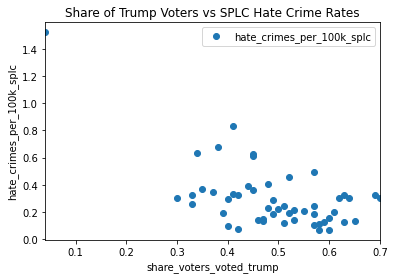

In [5]:
#visualization of share of trump voters versus splc hate crime 
data.plot(x='share_voters_voted_trump', y='hate_crimes_per_100k_splc', style='o')
plt.title('Share of Trump Voters vs SPLC Hate Crime Rates')
plt.xlabel('share_voters_voted_trump')
plt.ylabel('hate_crimes_per_100k_splc')
plt.show()


The results of this query and analysis show that the share of trump voters may not be significant in explaining high rates of hate crimes.

### High School Graduates

The data uses the share of adults aged 25 years or older with a high school degree in 2009. The below table shows the share of the population with a high school degree in states where the hate crime reported by the FBI is higher than the average of 2.367613. Nearly every state (16 out of 21) listed in the table has a share of the population with a high school degree greater than the average of 0.869118. Then, looking at the scatterplot of the high school degree population versus the hate crimes reported by the FBI, a positive trend can be seen, but it does not appear to be a high correlation between the two variables. 

In [6]:
#query to explore share high school degree versus fbi hate crime statistics
dfHighSchool_fbi = data[['state','share_population_with_high_school_degree','avg_hatecrimes_per_100k_fbi']].sort_values(by='avg_hatecrimes_per_100k_fbi',ascending=False)
dfHighSchool_fbi[dfHighSchool_fbi['avg_hatecrimes_per_100k_fbi'] > mean_fbi] 



,state,share_population_with_high_school_degree,avg_hatecrimes_per_100k_fbi
8,District of Columbia,0.871,10.953480
21,Massachusetts,0.890,4.801899
34,North Dakota,0.901,4.741070
30,New Jersey,0.874,4.413203
17,Kentucky,0.817,4.207890
47,Washington,0.897,3.817740
6,Connecticut,0.886,3.772701
23,Minnesota,0.915,3.612412
2,Arizona,0.842,3.413928
37,Oregon,0.891,3.394886


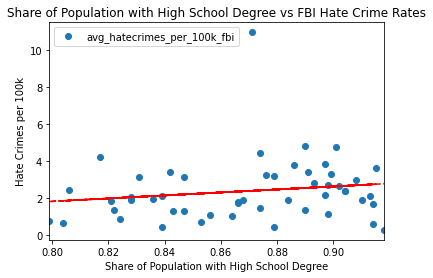

In [7]:
#visualization of share of high school degree versus fbi hate crime 
data.plot(x='share_population_with_high_school_degree', y = 'avg_hatecrimes_per_100k_fbi', style = 'o')
x = data['share_population_with_high_school_degree']
y = data['avg_hatecrimes_per_100k_fbi']
plt.title('Share of Population with High School Degree vs FBI Hate Crime Rates')
plt.xlabel('Share of Population with High School Degree')
plt.ylabel('Hate Crimes per 100k')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

The below table shows the share of the population with a high school degree in states where the hate crime rate from SPLC is higher than the average value of 0.304093. From this table, we can see that 14 out of the 18  states listed in the table has a share of the population with a high school degree greater than the average of 0.869118. Then, looking at the scatterplot of the high school population versus the hate crimes reported by the SPLC, a positive trend can be seen. Compared to the previous results, there appears to be a higher correlation between the high school degree rate and the hate crimes reported by the SPLC during the 10 days following the 2016 election. There still does not appear to be a high correlation between the two variables though.

In [8]:
#query to explore share high school degree versus splc hate crime statistics
dfHighSchool_splc = data[['state','share_population_with_high_school_degree','hate_crimes_per_100k_splc']].sort_values(by='hate_crimes_per_100k_splc', ascending=False)
dfHighSchool_splc[dfHighSchool_splc['hate_crimes_per_100k_splc'] > mean_splc]

,state,share_population_with_high_school_degree,hate_crimes_per_100k_splc
8,District of Columbia,0.871,1.522302
37,Oregon,0.891,0.832850
47,Washington,0.897,0.677488
21,Massachusetts,0.890,0.630811
23,Minnesota,0.915,0.627480
19,Maine,0.902,0.615574
26,Montana,0.908,0.495491
15,Iowa,0.914,0.454427
22,Michigan,0.879,0.403779
5,Colorado,0.893,0.390523


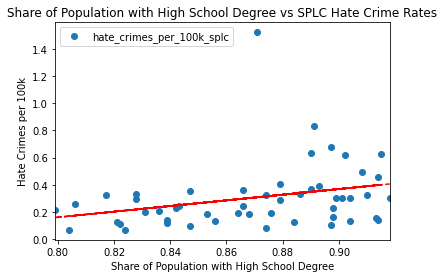

In [9]:
#visualization of share of high school degree versus splc hate crime 
data.plot(x='share_population_with_high_school_degree', y = 'hate_crimes_per_100k_splc', style = 'o')
x = data['share_population_with_high_school_degree']
y = data['hate_crimes_per_100k_splc']
plt.title('Share of Population with High School Degree vs SPLC Hate Crime Rates')
plt.xlabel('Share of Population with High School Degree')
plt.ylabel('Hate Crimes per 100k')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()


### Hate Crimes by States

We looked at how the FBI hate crimes compared for all 50 states. From 2010-2015, about 36,000 hate crimes were reported to the FBI from 2010 through 2015. District of Columbia showed the highest hate crime per 100,000 population and Wyoming the lowest. 


In [10]:
# Sort data by splc and fbi data
dataset = data.round(3)
datasplc= dataset.sort_values('hate_crimes_per_100k_splc')
datafbi= dataset.sort_values('avg_hatecrimes_per_100k_fbi')

listfbi=[]
for i in datafbi['avg_hatecrimes_per_100k_fbi']:
    listfbi.append(i)
highest_index=len(listfbi)-1

#highest hate crime
high_hatecrime=listfbi[highest_index]

### 2010-2015: FBI Hate Crime Data Sorted by States

C:\Users\clair\Anaconda3\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


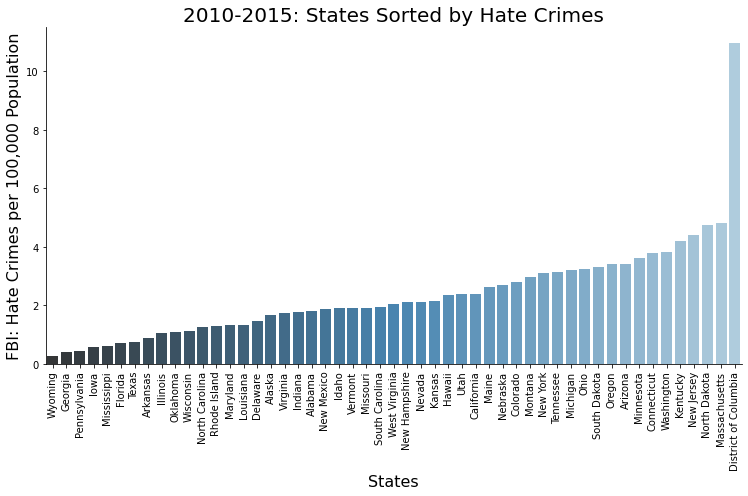

In [11]:
# Sort data by splc and fbi data
datasplc= dataset.sort_values('hate_crimes_per_100k_splc')
datafbi= dataset.sort_values('avg_hatecrimes_per_100k_fbi')

# Plot bar graph for fbi data
a = sns.catplot("state", "avg_hatecrimes_per_100k_fbi", data=datafbi, kind="bar", size=7, aspect=1.5, legend=False, palette="Blues_d")
a.set_xticklabels(rotation=90)

plt.title('2010-2015: States Sorted by Hate Crimes', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('FBI: Hate Crimes per 100,000 Population',size= "16")          
plt.tight_layout()
plt.show()

### 2010-2015 SPLC Hate Crime Data Sorted by States

SPLC showed lower hate crime per 100,000 population. Simliar to FBI data, SPLC also showed highest hate crime in District of Columbia. Mississippi was the state with the lowest hate crime. 

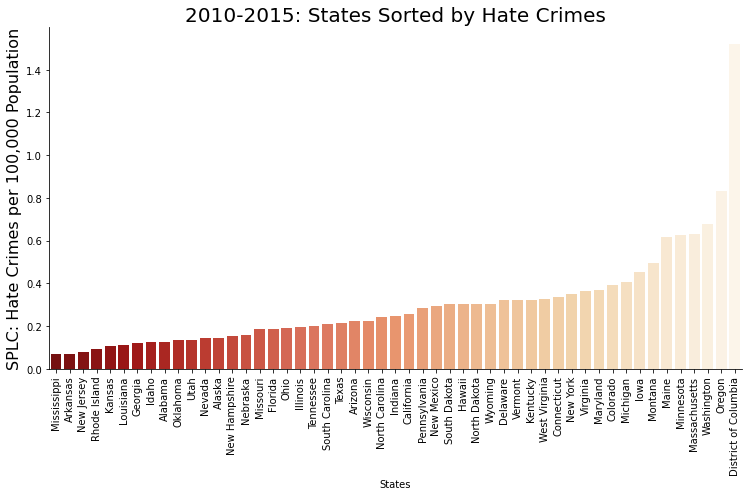

In [12]:
# Plot bar graph for splc data
b = sns.catplot("state", "hate_crimes_per_100k_splc", data=datasplc, kind="bar", size=7, aspect=1.5, legend=False, palette="OrRd_r")
b.set_xticklabels(rotation=90)

plt.title('2010-2015: States Sorted by Hate Crimes', size= "20")
plt.xlabel('States')

plt.ylabel('SPLC: Hate Crimes per 100,000 Population',size= "16")            
plt.tight_layout()
plt.show()

### Median Household Income

The study uses median income reported by Kaiser Family Foundation in 2015. We have generated a graph to show how the median income distribution looked like for all of the states in 2015. 

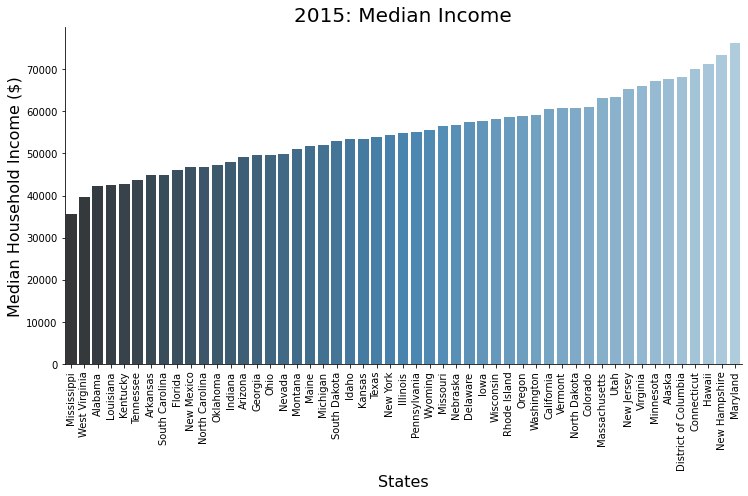

In [13]:
#2015 Median Household Income
dataincome= dataset.sort_values('median_household_income')
medincome = sns.catplot("state", "median_household_income", data=dataincome, kind="bar", size=7, aspect=1.5, legend=False, palette="Blues_d")
medincome.set_xticklabels(rotation=90)

plt.title('2015: Median Income', size= "20")
plt.xlabel('States',size= "16")
plt.ylabel('Median Household Income ($)',size= "16") 
plt.tight_layout()
plt.show()

### Median Household Income: Scatter Plot for SPLC vs FBI

We then plotted a scatter plot for FBI and SPLC hate crime against median household income to see if we could observe any trends between median income and the hate crime. The hate crime is randomly scattered across various median household income and there was no apparent relationship between median household income and the hate crime per capita.

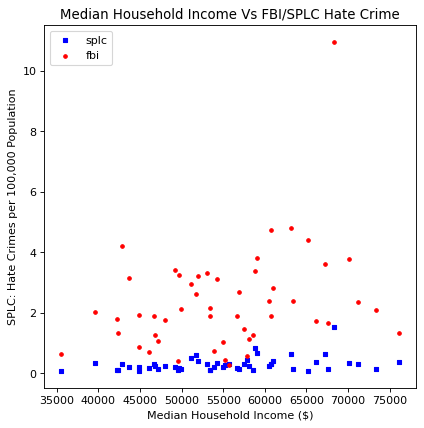

In [14]:
##scatter plot for how SPLC/FBI hatecrime relate to median income
fig = plt.figure(figsize=(6, 6), dpi=80)

ax = fig.add_subplot(111)


plots=ax.scatter(x="median_household_income", y="hate_crimes_per_100k_splc",data=datasplc, s=10, c='b', marker="s", label='splc')
plotf=ax.scatter(x="median_household_income", y="avg_hatecrimes_per_100k_fbi",data=datafbi, s=10, c='r', marker="o", label='fbi')
plt.legend(loc='upper left');

dataset= dataset[dataset['avg_hatecrimes_per_100k_fbi'] > 0]
dataset = dataset[dataset['hate_crimes_per_100k_splc'] > 0] #Southern Poverty Law Center

plt.title('Median Household Income Vs FBI/SPLC Hate Crime')
plt.xlabel('Median Household Income ($)')

plt.ylabel('SPLC: Hate Crimes per 100,000 Population')
plt.show()


### Gini Index

Gini index is a measure of statistical dispersion intended to represent the income or wealth distribution of a nation's residents, and is the most commonly used measurement of inequality. From our initial data anlysis, Gini index showed a strong correlation to hate crime. The scatter plots show gini index against SPLC and FBI hate crime per 100k population.

C:\Users\clair\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\clair\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


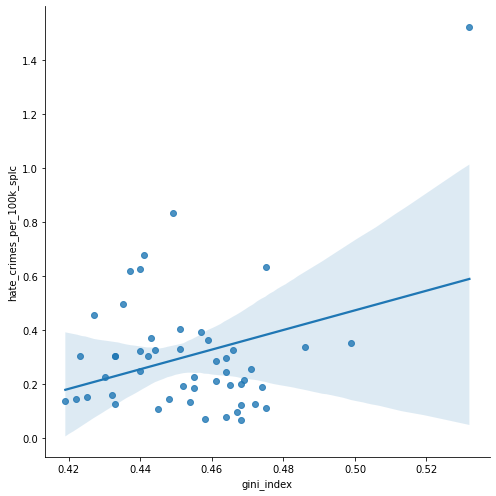

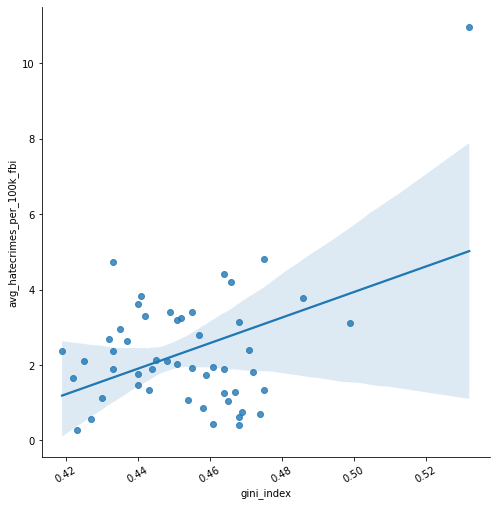

In [15]:
grid = sns.lmplot('gini_index', 'hate_crimes_per_100k_splc', datasplc, size=7, palette="Blues_d",truncate=True)
grid = sns.lmplot('gini_index', 'avg_hatecrimes_per_100k_fbi', datafbi, size=7, palette="Blues_d",truncate=True)

# Rotate the labels on x-axis
grid.set_xticklabels(rotation=30)

# Show the plot
plt.show()

# **2010-2015 Multiple Linear Regression Analysis**

First, we decided to regress all of the variables against the FBI average hatecrimes. By doing this full regression first, we were able to analyze the results and look for variables with significant p-values ('P<|t|' < 0.05). Based on the output of the full model regression, the gini index was the most significant factor, followed by the share of population with high school degree. 

In [16]:

mod = smf.ols(formula = 'avg_hatecrimes_per_100k_fbi ~ median_household_income + share_unemployed_seasonal + share_population_in_metro_areas + share_population_with_high_school_degree + share_non_citizen + share_white_poverty + gini_index + share_non_white', data=data)
modFit = mod.fit()

#display summary of model
print(modFit.summary())

                                 OLS Regression Results                                
Dep. Variable:     avg_hatecrimes_per_100k_fbi   R-squared:                       0.485
Model:                                     OLS   Adj. R-squared:                  0.387
Method:                          Least Squares   F-statistic:                     4.952
Date:                         Mon, 27 Apr 2020   Prob (F-statistic):           0.000234
Time:                                 20:00:28   Log-Likelihood:                -81.891
No. Observations:                           51   AIC:                             181.8
Df Residuals:                               42   BIC:                             199.2
Df Model:                                    8                                         
Covariance Type:                     nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------

Running the regression of the reduced model, we can see that both variables are significant. The adjusted R-squared value of the model is 0.408 which indicates that the correlation between the regressors and the response is not very strong.  

In [17]:
#Based on the p-values in output, going to make a reduced model with significant contributors

#run and fit model
reducedMod = smf.ols(formula = 'avg_hatecrimes_per_100k_fbi ~ share_population_with_high_school_degree + gini_index', data=data)
redFit = reducedMod.fit()
redFit.params

#display summary statistics
print(redFit.summary())

                                 OLS Regression Results                                
Dep. Variable:     avg_hatecrimes_per_100k_fbi   R-squared:                       0.432
Model:                                     OLS   Adj. R-squared:                  0.408
Method:                          Least Squares   F-statistic:                     18.24
Date:                         Mon, 27 Apr 2020   Prob (F-statistic):           1.28e-06
Time:                                 20:00:30   Log-Likelihood:                -84.419
No. Observations:                           51   AIC:                             174.8
Df Residuals:                               48   BIC:                             180.6
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------

The 3-dimensional scatterplot below visualizes the relationship between the two predictors (share of population with a high school degree and gini index) and the response (FBI reported average hatecrimes per 100k). From this plot, we can see the positive correlation between the predictors and the response, but there appears to be a stronger relationship between gini index and the response. 

<IPython.core.display.Javascript object>


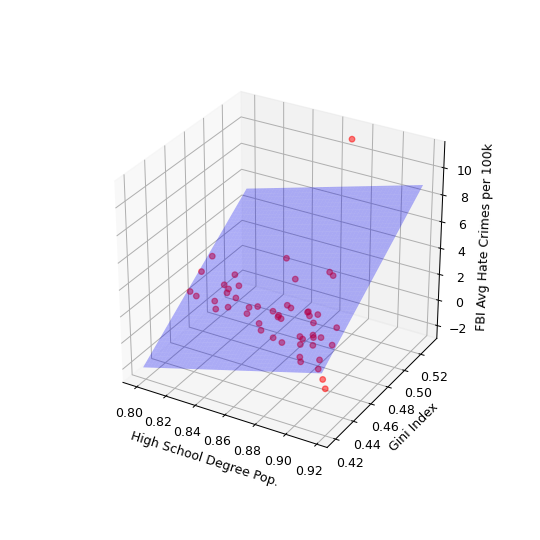

In [21]:
get_ipython().run_line_magic('matplotlib', 'notebook') #may have to run twice for interacivity to load correctly

#Prepare the data for Visualization
x_surf, y_surf = np.meshgrid(np.linspace(data.share_population_with_high_school_degree.min(),data.share_population_with_high_school_degree.max(), 100), np.linspace(data.gini_index.min(),data.gini_index.max(), 100))
onlyX = pd.DataFrame({'share_population_with_high_school_degree': x_surf.ravel(), 'gini_index': y_surf.ravel()})
fittedY = redFit.predict(exog=onlyX)

#Convert the predicted result in an array
fittedY = np.array(fittedY)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
ax.scatter(data['share_population_with_high_school_degree'],data['gini_index'],data['avg_hatecrimes_per_100k_fbi'],c='red', marker='o', alpha=0.5)
ax.plot_surface(x_surf,y_surf,fittedY.reshape(x_surf.shape), color='blue', alpha=0.3)
ax.set_xlabel('High School Degree Pop.')
ax.set_ylabel('Gini Index')
ax.set_zlabel('FBI Avg Hate Crimes per 100k')
plt.show()

In [19]:
#Now going to add the predicted values and residuals to the table
data['PredictedFBI'] = redFit.predict(data[['share_population_with_high_school_degree','gini_index']])
data['ResidualsFBI'] = data['avg_hatecrimes_per_100k_fbi'] - data['PredictedFBI']

The residuals are used to assess the OLS assumptions of the model. The regression plot indicates that the constant variance assumption is violated, so a transformation would be required. Since we are exploring the base relationships of these variables, further transformations are not done in this program, but would be required if one wants to use the model for predictions. 

<IPython.core.display.Javascript object>


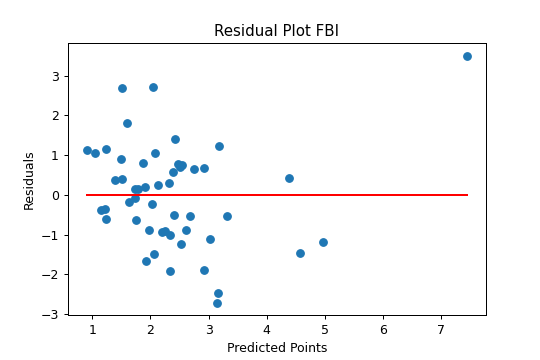

In [22]:
#Now can make residual plot 
#may have to run twice for interacivity to load correctly
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data['PredictedFBI'],data['ResidualsFBI'])
ax.plot(data['PredictedFBI'],data['PredictedFBI']*0, 'r-')
ax.set_title("Residual Plot FBI")
ax.set_xlabel("Predicted Points")
ax.set_ylabel("Residuals")

plt.show()

Next, we decided to regress all of the variables against the SPLC average hatecrimes. We want to determine the most significant contributor for the hate crimes during the 10 days after the 2016 election and compare the results to the significant factors for 2010 to 2015. By doing this full regression first, we were able to analyze the results and look for variables with significant p-values ('P<|t|' < 0.05). Based on the output of the full model regression, the gini index was the most significant factor, followed by the share of population with high school degree.

In [23]:
####-----------Now using SPLC Hate Crime Data------####

#run and fit the model
modSPLC = smf.ols(formula = 'hate_crimes_per_100k_splc ~ median_household_income + share_unemployed_seasonal + share_population_in_metro_areas + share_population_with_high_school_degree + share_non_citizen + share_white_poverty + gini_index + share_non_white', data=data)
modSPLCFit = modSPLC.fit()

#display summary of model
print(modSPLCFit.summary())

                                OLS Regression Results                               
Dep. Variable:     hate_crimes_per_100k_splc   R-squared:                       0.520
Model:                                   OLS   Adj. R-squared:                  0.429
Method:                        Least Squares   F-statistic:                     5.690
Date:                       Mon, 27 Apr 2020   Prob (F-statistic):           6.51e-05
Time:                               20:02:03   Log-Likelihood:                 19.139
No. Observations:                         51   AIC:                            -20.28
Df Residuals:                             42   BIC:                            -2.893
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Running the regression of the reduced model, we can see that both variables are significant. The adjusted R-squared value of the model is 0.427 which indicates that the correlation between the regressors and the response is not very strong.

In [24]:

#Based on the p-values in output, going to make a reduced model with significant contributors

#run and fit model
reducedModSPLC = smf.ols(formula = 'hate_crimes_per_100k_splc ~ share_population_with_high_school_degree + gini_index', data=data)
redFitSPLC = reducedModSPLC.fit()
redFitSPLC.params

#display summary statistics
print(redFitSPLC.summary())


                                OLS Regression Results                               
Dep. Variable:     hate_crimes_per_100k_splc   R-squared:                       0.450
Model:                                   OLS   Adj. R-squared:                  0.427
Method:                        Least Squares   F-statistic:                     19.64
Date:                       Mon, 27 Apr 2020   Prob (F-statistic):           5.87e-07
Time:                               20:02:05   Log-Likelihood:                 15.662
No. Observations:                         51   AIC:                            -25.32
Df Residuals:                             48   BIC:                            -19.53
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

The 3-dimensional scatterplot below visualizes the relationship between the two predictors (share of population with a high school degree and gini index) and the response (SPLC reported average hatecrimes per 100k). From this plot, we can see the positive correlation between the predictors and the response, but there appears to be a stronger relationship between gini index and the response.

<IPython.core.display.Javascript object>


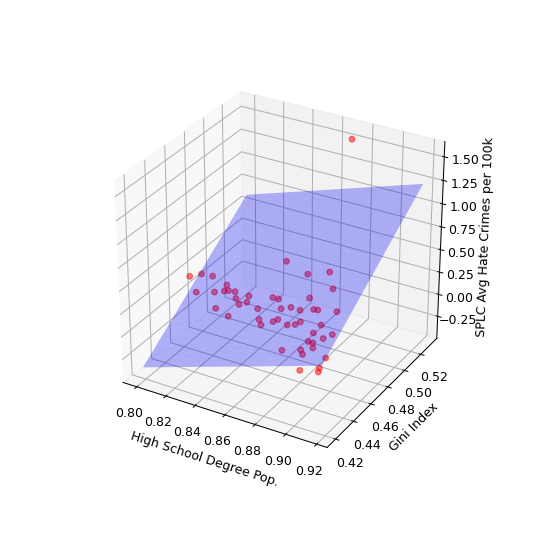

In [25]:
#may have to run twice for interacivity to load correctly
#Prepare the data for Visualization
x_surf2, y_surf2 = np.meshgrid(np.linspace(data.share_population_with_high_school_degree.min(),data.share_population_with_high_school_degree.max(), 100), np.linspace(data.gini_index.min(),data.gini_index.max(), 100))
onlyX2 = pd.DataFrame({'share_population_with_high_school_degree': x_surf2.ravel(), 'gini_index': y_surf2.ravel()})
fittedY2 = redFitSPLC.predict(exog=onlyX2)

#Convert the predicted result in an array
fittedY2 = np.array(fittedY2)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
ax.scatter(data['share_population_with_high_school_degree'],data['gini_index'],data['hate_crimes_per_100k_splc'],c='red', marker='o', alpha=0.5)
ax.plot_surface(x_surf2,y_surf2,fittedY2.reshape(x_surf2.shape), color='blue', alpha=0.3)
ax.set_xlabel('High School Degree Pop.')
ax.set_ylabel('Gini Index')
ax.set_zlabel('SPLC Avg Hate Crimes per 100k')
plt.show()

In [26]:
#End interactive 3d plots 
get_ipython().run_line_magic('matplotlib', 'inline')

In [27]:
#Now going to add the predicted values and residuals to the table
data['PredictedSPLC'] = redFitSPLC.predict(data[['share_population_with_high_school_degree','gini_index']])
data['ResidualsSPLC'] = data['hate_crimes_per_100k_splc'] - data['PredictedSPLC']

The residuals are used to assess the OLS assumptions of the model. The regression plot indicates that the constant variance assumption is violated, so a transformation would be required. Since we are exploring the base relationships of these variables, further transformations are not done in this program, but would be required if one wants to use the model for predictions.

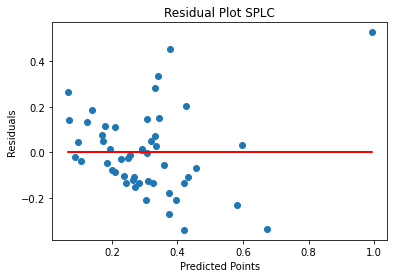

In [28]:
#Now can make residual plot 

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(data['PredictedSPLC'],data['ResidualsSPLC'])
ax.plot(data['PredictedSPLC'],data['PredictedSPLC']*0, 'r-')
ax.set_title("Residual Plot SPLC")
ax.set_xlabel("Predicted Points")
ax.set_ylabel("Residuals")
#ax2.set_xticks(range(int(min(data['Predicted'])),int(max(data['Predicted']))+1))

plt.show()

The results of the multiple linear regression for the responses FBI and SPLC average hatecrimes are consistent with each other: the gini index is the most significant factor followed by the share of population with high school degree. The level of inequaltiy as a significant factor is consistent with our initial assumptions. This would help to argue the case that addressing issues of inequality could potentially help lower hatecrime rates in those areas. However, the share of population with high school degree having a positive correlation with hate crime rates was unexpected. One would probably assume that more educuated areas would have lower rates of hate crime. This is still a very limited model though and does not include other potential factors such as higher education rates. 

# 2018 Hate Crime Data Analysis

In addition to 2010-2015 hate crime data, we webscraped 2018 hate crime data from the FBI website to explore different types of hate crime and analyze hate crime trend with more variables to compare to 2010-2015. We created web scrape function to pull data from the FBI webpage (for any year) and put into a dataframe.

## Webscrape

In [29]:
state_dict = states.mapping('abbr', 'name')
abbr = state_dict.keys()

## make states lowercase
for state in abbr:
    state_dict[state] = state_dict[state].lower()
    
    
######################################################################################################    
# SOURCE: https://realpython.com/python-web-scraping-practical-introduction/
######################################################################################################

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    and return the html table on the webpage
    """
    try:
        with closing(get(url, timeout=3.5)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
######################################################################################################
############# END of https://realpython.com/python-web-scraping-practical-introduction/ ##############
######################################################################################################

bad_links = [] # will hold all bad links

def get_table(url):
    """
    Grabs table from specified url if valid.
    If it is not valid adds the url to bad_links
    list.
    """
    if url in bad_links:
        return None
    html = simple_get(url)
    if html is None:
        bad_links.append(url)
        return None
    soup = BeautifulSoup(html, 'lxml')
    table = soup.find_all('table')[0]
    return table

##---- unittest just for this one ##--Landon
def get_state_DF_from_table(url, table_num, status_msg=True):
    """
    Read tables 13 & 14 in FBI UCR data and convert to DataFrames.
    This function returns a formatted df with of the state data.
    See Website: https://ucr.fbi.gov/hate-crime/2018/tables/table-14-state-cuts/
    """
    table = get_table(url)
    if table is None:
        return table
    
    
    if status_msg:
        print("Creating a DF for table at: {}".format(url))
    
    if(table_num == "14"):
        df = pd.read_html(str(table), header=[1], index_col=[0,1])[0]
        df.columns = pd.MultiIndex.from_tuples([(u'Zero data per quarter',  u'1st quarter'),
                (u'Zero data per quarter',  u'2nd quarter'),
                (u'Zero data per quarter',  u'3rd quarter'),
                (u'Zero data per quarter',  u'4th quarter'),
                (u'', u'Population')], names=[u'', u'Agency'])
    elif(table_num == "13"):
        df = pd.read_html(str(table), header=[0,1], index_col=[0,1])[0]
        df.columns = pd.MultiIndex.from_tuples([(u'Number of incidents per bias motivation',  u'Race/Ethnicity/Ancestry'),
                (u'Number of incidents per bias motivation',  u'Religion'),
                (u'Number of incidents per bias motivation',  u'Sexual orientation'),
                (u'Number of incidents per bias motivation',  u'Disability'),
                (u'Number of incidents per bias motivation',  u'Gender'),
                (u'Number of incidents per bias motivation',  u'Gender Identity'),
                (u'Number of incidents per quarter',  u'1st quarter'),
                (u'Number of incidents per quarter',  u'2nd quarter'),
                (u'Number of incidents per quarter',  u'3rd quarter'),
                (u'Number of incidents per quarter',  u'4th quarter'),
                (u'', u'Population')], names=[u'', u'Agency'])
    else:
        return None
                                                              
                                                              
    df = df.fillna(" ")
    return df


def format_url(year, table_num, state):
    """
    Formats url for a GET request to
    FBI UCR website
    """
    url_string = "https://ucr.fbi.gov/hate-crime/{0}/tables/table-{1}-state-cuts/{2}.xls"
    return url_string.format(year,table_num,state).replace(" ", "_")

In [30]:
# WebScrape FBI Hate Crime by Details
# 
# Can add any years from 1995-2018 
#
# Takes awhile to run
#
# Add True param to get_state_DF_from_table
# Function to get progress messages

years = ["2018"]

# Only supports tables 13 and 14
table_nums = ["13"]

# make dict for DFs
stateDFs =  {key: {} for key in abbr}

# loop through years, states and tables 
for year in years:
    for i in abbr:
        # create a dict to store url for each table per state
        stateDFs[i]["urls"] = {key: None for key in table_nums}
        for table_num in table_nums:
            url = format_url(year, table_num, state_dict[i])
            stateDFs[i][table_num] = get_state_DF_from_table(url,table_num,False)
            stateDFs[i]["urls"][table_num] = None if url in bad_links else url       
            
            

### Hate Crime Categories

The code below extracts the totals row of each state data frame and puts it into a dataframe called hate_crime_totals.

In [31]:
totals_dict = {key:[] for key in abbr}

for a in abbr:
    if stateDFs[a]["13"] is not None:
        tmpDF = stateDFs[a]["13"].xs('Total')
        tmp_list = tmpDF.values.tolist()[0][0:6]
        totals_dict[a] = tmp_list
    else:
        tmp_list = [0,0,0,0,0,0]
        totals_dict[a] = tmp_list
        
hate_crime_totals = pd.DataFrame.from_dict(totals_dict, orient='index', columns=['Race/Ethnicity/Ancestry', 'Religion',
                                                             'Sexual orientation', 'Disability', 'Gender',
                                                            'Gender Identity'])       

The table is the resulting data frame showing hate crime incidents for each category for each state.

In [32]:
hate_crime_totals

,Race/Ethnicity/Ancestry,Religion,Sexual orientation,Disability,Gender,Gender Identity
AL,0.0,0.0,0.0,0.0,0.0,0.0
AK,4.0,2.0,0.0,1.0,0.0,0.0
AS,0.0,0.0,0.0,0.0,0.0,0.0
AZ,95.0,34.0,37.0,2.0,2.0,3.0
AR,10.0,1.0,1.0,1.0,0.0,0.0
CA,596.0,199.0,239.0,7.0,4.0,20.0
CO,78.0,16.0,24.0,2.0,0.0,3.0
CT,54.0,13.0,12.0,1.0,1.0,0.0
DK,0.0,0.0,0.0,0.0,0.0,0.0
DE,13.0,1.0,2.0,0.0,0.0,0.0


### US Census Data

We decided to consider potential factors similar to 2010-2015 data to analyze the effects of hate crime for 2018. The below is giving column names to the csv data downloaded from US Census website.

In [33]:
col_names = ["School System Expend", "Median Household Income", "Share Population White", "Gini Index", "Share HS Grad 18-24"]

census = pd.read_csv('https://raw.githubusercontent.com/hs4cf/CS-Python-Project/master/USCensus_data.csv', header=0, names = col_names)

In [34]:
census
hate_crime_totals = pd.concat([hate_crime_totals, census], axis=1)

### Census Data Cleaning

The code below shows our data cleaning methods replacing gini index data that contained null value with the mean gini index value. We then decided to combine sexual orientation, gender, and gender identity variables into one variable Sex/Gender. We also removed US territories from the US census data since they had a median household income of zero and we decided to focus on the fifty states.

In [35]:
mean_gini_index = hate_crime_totals['Gini Index'].mean()
hate_crime_totals['Gini Index'].fillna(mean_gini_index, inplace=True) 

hate_crime_totals['Sex/Gender'] = hate_crime_totals['Sexual orientation'] + hate_crime_totals['Gender'] + hate_crime_totals['Gender Identity']

hate_crime_totals = hate_crime_totals[hate_crime_totals['Median Household Income'] > 0]


### Hate Crimes Per 100,000 Population

The code below reads table-12 from the FBI website to calculate hate crimes per 100,000 population based on the number of incidents and population covered for each state.

In [36]:
summary_hateCrimes = "https://ucr.fbi.gov/hate-crime/2018/topic-pages/tables/table-12.xls"
table = get_table(summary_hateCrimes)
fbidata2018 = pd.read_html(str(table), header=[0])[0]

In [37]:
fbidata2018.rename(columns={'Participating state/Federal' : 'State'},inplace=True)
fbidata2018.rename(columns={'Populationcovered' : 'Population Covered'},inplace=True)
fbidata2018.rename(columns={'Totalnumber ofincidentsreported' : 'Number of Incidents'},inplace=True)

#Calculate Hate Crimes per 100k
data2018_100k = fbidata2018['Number of Incidents']/fbidata2018['Population Covered']*100000
fbidata2018['hate_crimes_per_100k']=data2018_100k
fbidata2018[1:52] #Display Data

,State,Number ofparticipatingagencies,Population Covered,Agenciessubmittingincidentreports,Number of Incidents,hate_crimes_per_100k
1,Alabama,98.0,1865517.0,0.0,0.0,0.000000
2,Alaska,32.0,733747.0,4.0,7.0,0.954007
3,Arizona,102.0,7135285.0,19.0,166.0,2.326466
4,Arkansas,286.0,2874960.0,9.0,13.0,0.452180
5,California,736.0,39520441.0,220.0,1063.0,2.689747
6,Colorado,217.0,5512017.0,37.0,121.0,2.195204
7,Connecticut,97.0,3150064.0,34.0,81.0,2.571376
8,Delaware,63.0,962453.0,10.0,16.0,1.662419
9,District of Columbia,2.0,702455.0,2.0,213.0,30.322227
10,Florida,651.0,20922562.0,54.0,141.0,0.673914


### Hate Crime Data Frame

In [38]:
sLength = len(hate_crime_totals['Religion'])
hate_crime_totals["hate_crimes_per_100k"] = pd.Series(np.random.randn(sLength), index=hate_crime_totals.index)

#code to bring 'hate_crimes_per_100k' and 'Population Covered' from previous dataframe into hate_crime_totals dataframe
index = list(hate_crime_totals.index.values)
state_dict = states.mapping('abbr', 'name')
abbr = state_dict.keys()
for i in index:
    hate_crime_totals.at[i,"hate_crimes_per_100k"] = fbidata2018.loc[fbidata2018['State'] == state_dict[i], 'hate_crimes_per_100k'].iloc[0] 
    hate_crime_totals.at[i,"population_covered"] = fbidata2018.loc[fbidata2018['State'] == state_dict[i], 'Population Covered'].iloc[0]

#code to normalize School System Expenditure by each state's population covered
hate_crime_totals['School_system_expend_by_pop'] = hate_crime_totals['School System Expend'].div(hate_crime_totals['population_covered'])
    
hate_crime_totals

,Race/Ethnicity/Ancestry,Religion,Sexual orientation,Disability,Gender,Gender Identity,School System Expend,Median Household Income,Share Population White,Gini Index,Share HS Grad 18-24,Sex/Gender,hate_crimes_per_100k,population_covered,School_system_expend_by_pop
AL,0.0,0.0,0.0,0.0,0.0,0.0,2556496,49861,67.7,0.403147,35.0,0.0,0.000000,1865517.0,1.370395
AK,4.0,2.0,0.0,1.0,0.0,0.0,1013896,74346,64.4,0.432200,45.7,0.0,0.954007,733747.0,1.381806
AZ,95.0,34.0,37.0,2.0,2.0,3.0,3051375,59246,78.0,0.461300,33.5,42.0,2.326466,7135285.0,0.427646
AR,10.0,1.0,1.0,1.0,0.0,0.0,1824239,47062,76.5,0.484500,37.3,1.0,0.452180,2874960.0,0.634527
CA,596.0,199.0,239.0,7.0,4.0,20.0,27572412,75277,59.5,0.491200,30.5,263.0,2.689747,39520441.0,0.697675
CO,78.0,16.0,24.0,2.0,0.0,3.0,3475055,71953,84.1,0.456100,32.2,27.0,2.195204,5512017.0,0.630451
CT,54.0,13.0,12.0,1.0,1.0,0.0,3360805,76348,75.2,0.501400,29.6,13.0,2.571376,3150064.0,1.066901
DE,13.0,1.0,2.0,0.0,0.0,0.0,619504,64805,68.2,0.458700,34.8,2.0,1.662419,962453.0,0.643672
DC,99.0,12.0,68.0,0.0,1.0,33.0,432742,85203,42.2,0.524300,31.8,102.0,30.322227,702455.0,0.616042
FL,71.0,29.0,35.0,1.0,0.0,5.0,8440670,55462,74.6,0.488700,32.2,40.0,0.673914,20922562.0,0.403424


### 2018 Hate Crime Incidents 

The bar graph displays hate crime incidents reported for each state using the data webscraped from the FBI website. California had the most hate crime incidents but when population was taken into account, District of Columbia has the highest hate crime rate per 100,000 population. 

C:\Users\clair\Anaconda3\lib\site-packages\seaborn\categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


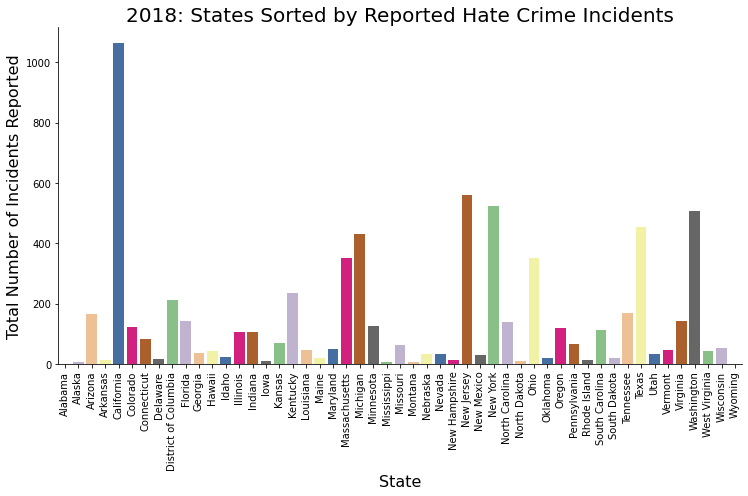

In [39]:
fbi_2018 = fbidata2018[1:52]#read lines for State data

# Plot bar graph for fbi data
fbi2018plt = sns.catplot("State","Number of Incidents", data=fbi_2018, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
fbi2018plt.set_xticklabels(rotation=90)

plt.title('2018: States Sorted by Reported Hate Crime Incidents', size='20')
plt.xlabel('State', size='16')
plt.ylabel('Total Number of Incidents Reported', size='16')
plt.tight_layout()
plt.show() # Show plot

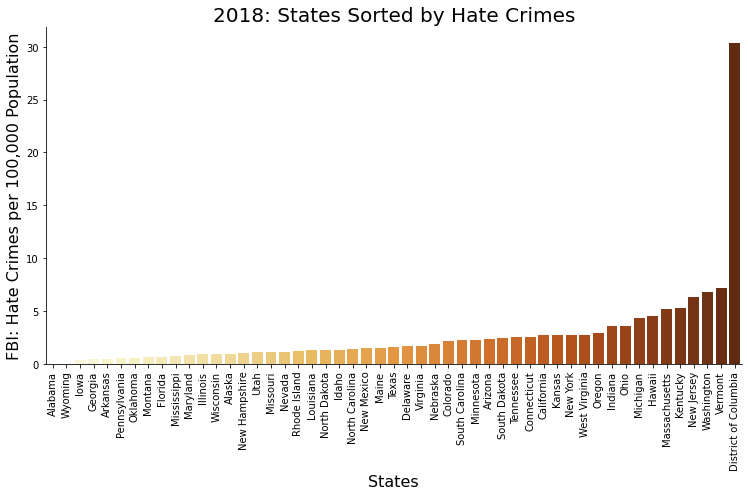

In [40]:
# Plot bar graph for fbi data
fbi_2018_sorted= fbi_2018.sort_values('hate_crimes_per_100k')
fbi2018plt = sns.catplot("State","hate_crimes_per_100k", data=fbi_2018_sorted, kind="bar", size=7, aspect=1.5, legend=False, palette="YlOrBr")
fbi2018plt.set_xticklabels(rotation=90)

plt.title('2018: States Sorted by Hate Crimes', size='20')
plt.xlabel('States', size='16')
plt.ylabel('FBI: Hate Crimes per 100,000 Population', size='16')   
plt.tight_layout()
plt.show()

In [41]:
#Web Scrape details of Hate Crime Category

urlcat = 'https://ucr.fbi.gov/hate-crime/2018/topic-pages/tables/table-1.xls'
responsecat    = requests.get(urlcat) # get url
htmlcat    = responsecat.content # get url content
soupcat = BeautifulSoup(htmlcat, 'lxml') #parse using BeautfulSoup html parsing library
tablecat = soupcat.find('div', attrs={'id':'tablecontainer'}) # get the category tables that's divided in 'div' with 'wsod_hosStocks' attributes


appendedlistcat=[]
fbiCat2018 = pd.read_csv('Category2018.csv')

def scrape():    
    for row in tablecat.find_all('tr'):
        for header in tablecat.find_all('th'):# for each state in the table

            header = (row.find_all('th')) #header contains states
            header=[state.text.strip() for state in header] #strip text <th>  

            cols=(row.find_all('td')) #data for each header
            cols=[x.text.strip().replace(',','') for x in cols] #strip text <td> and remove commas

            for each_cols in cols:
                x = re.findall('[0-9]+', each_cols); #filter only numbers [0-9]
                x = ''.join(map(str, x)) #map strings and join 

                if (len(x) > 0): #append data for each header if length of data is not empty
                    header.append(int(x)) 

        appendedlistcat.append(header) #append all data to a list

    outfilecat = open("./Category2018.csv", "w") #open and write the list into csv file 
    writer = csv.writer(outfilecat)

    writer.writerows(appendedlistcat) #add appendedlist to csv file
    outfilecat.close()
    fbiCat2018 = pd.read_csv(os.path.join(THIS_DIR, 'Category2018.csv'))


In [42]:
def rename_columns():

    fbiCat2018.at[4,'Bias motivation']= 'Anti-Black'
    fbiCat2018.at[5,'Bias motivation']= 'Anti-American Indian'
    fbiCat2018.at[7,'Bias motivation']= 'Anti-Native Hawaiian'
    fbiCat2018.at[8,'Bias motivation']= 'Anti-Multi Races'
    fbiCat2018.at[10,'Bias motivation']= 'Anti-Hispanic'
    fbiCat2018.at[11,'Bias motivation']= 'Anti-Other Race'

    fbiCat2018.at[16,'Bias motivation']= 'Anti-Islamic'
    fbiCat2018.at[17,'Bias motivation']= 'Anti-Other Relig.'
    fbiCat2018.at[18,'Bias motivation']= 'Anti-Multi Relig.'
    fbiCat2018.at[20,'Bias motivation']= 'Anti-Jehovah''s Wit.'
    fbiCat2018.at[21,'Bias motivation']= 'Anti-Eastrn Orthod.'
    fbiCat2018.at[22,'Bias motivation']= 'Anti-Other Christn.'
    fbiCat2018.at[26,'Bias motivation']= 'Anti-Atheism'
    fbiCat2018.at[30,'Bias motivation']= 'Anti-Les/Gay/Bi/Transgdr.'

    return fbiCat2018

### Hate Crime Categories Visualizations

Hate crime incidents related to race/ethnicity was the hightest, and then followed by reglion and sexual orientation based hate crimes. Pie chart below shows 56.8% of hate crime incidents were related to race/ethnicity. Bar graph shows number of incidents for each hate crime category.

Race/Ethnicity/Ancestry: 4047
Religion: 1419
Sexual Orientation: 1196
Disability: 159
Gender: 47
Gender Identity: 168
Multiple-Bias Incidents3 84


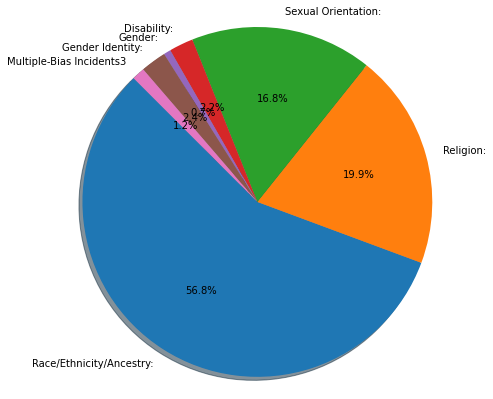

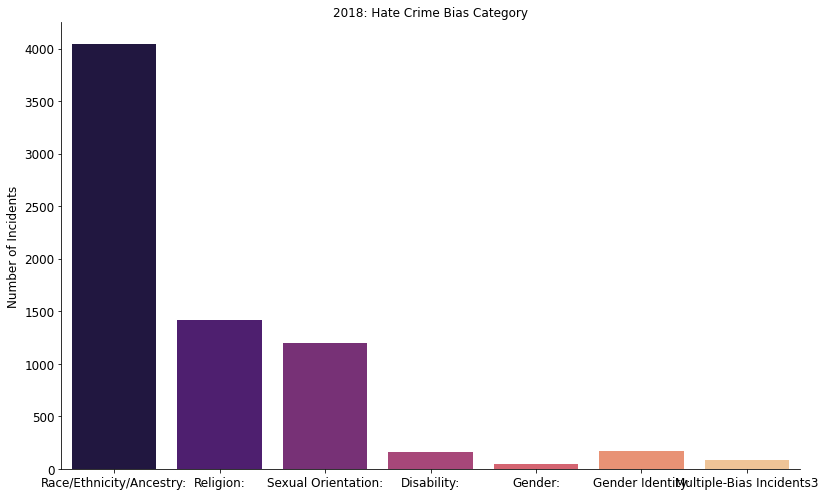

In [43]:
category_x = [fbiCat2018['Bias motivation'][2],fbiCat2018['Bias motivation'][12],fbiCat2018['Bias motivation'][27],fbiCat2018['Bias motivation'][33],fbiCat2018['Bias motivation'][36],fbiCat2018['Bias motivation'][39],fbiCat2018['Bias motivation'][42]]
category_y = [fbiCat2018['Incidents'][2],fbiCat2018['Incidents'][12],fbiCat2018['Incidents'][27],fbiCat2018['Incidents'][33],fbiCat2018['Incidents'][36],fbiCat2018['Incidents'][39],fbiCat2018['Incidents'][42]]

for i in range(0,7):
    print(category_x[i],category_y[i])

# Plot Pie Chart for Each Category 
def plotpie_category():
   
    fig = plt.figure(figsize=[7,7])
    ax1= fig.add_subplot(111)
    
    labels = category_x
    sizes = category_y

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=135)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

# Plot Bar Graph for Each Category 
def plotbar_category():
    fbi2018cat = sns.catplot(category_x, category_y, data=fbiCat2018, kind="bar", size=7, aspect=1.65, legend=False, palette="magma")

    fbi2018cat.set_xticklabels(rotation=0,size="12")
    fbi2018cat.set_yticklabels(rotation=0,size="12")

    plt.title('2018: Hate Crime Bias Category', size= "12")
    plt.xlabel('', size= "1")
    plt.ylabel('Number of Incidents', size= "12")
    plt.tight_layout()
    plt.show() # Show plot    

plotpie_category()
plotbar_category()

### Breakdown of each Cateogory

The bar graph shows detail breakdown for race/ethnicity category. Anti-black hate crimes were the highest.

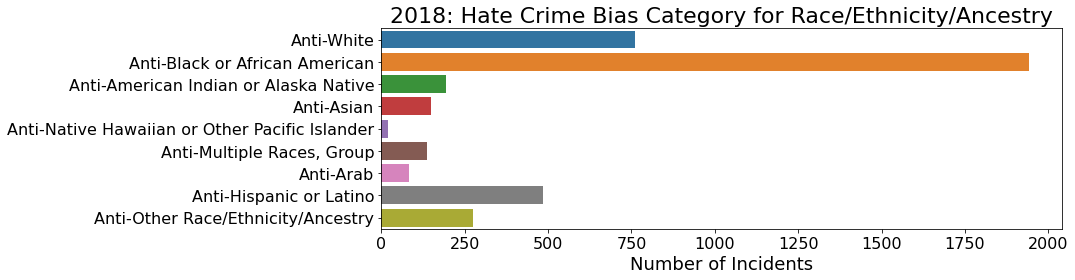

In [48]:
# Plot Bar Graph for Race Category
#def plot_category_race():

catrace_x=[]
for each_cat in fbiCat2018['Bias motivation'][3:12]:
    catrace_x.append(each_cat)

catrace_y=[]
for each_cat in fbiCat2018['Incidents'][3:12]:
    catrace_y.append(each_cat)

fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
catorace=sns.barplot(x = catrace_y, y = catrace_x, ax=ax, data=fbiCat2018)

ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

plt.title('2018: Hate Crime Bias Category for Race/Ethnicity/Ancestry', size= "22")
plt.ylabel('', size= "1")
plt.xlabel('Number of Incidents', size= "18")

fig.tight_layout()
plt.show()

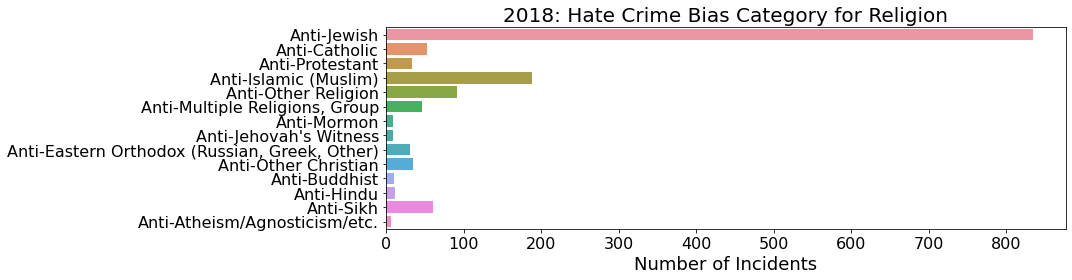

In [45]:
def plot_category_rel():

    catrelg_x=[]
    for each_cat in fbiCat2018['Bias motivation'][13:27]:
        catrelg_x.append(each_cat)

    catrelg_y=[]
    for each_cat in fbiCat2018['Incidents'][13:27]:
        catrelg_y.append(each_cat)
    
    fig_dims = (15, 4)
    fig, ax = plt.subplots(figsize=fig_dims)
    catorelg=sns.barplot(x = catrelg_y, y = catrelg_x, ax=ax, data=fbiCat2018)

    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    
    plt.title('2018: Hate Crime Bias Category for Religion', size= "20")
    plt.ylabel('', size= "16")
    plt.xlabel('Number of Incidents', size= "18")

    fig.tight_layout()
    plt.show() # Show plot

plot_category_rel()

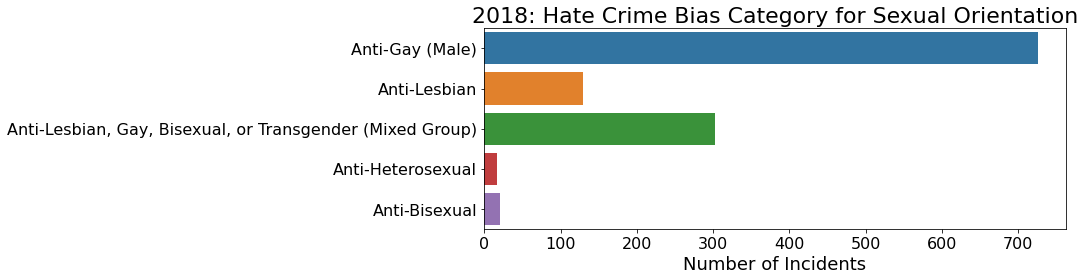

In [46]:
# Plot Bar Graph for Each Category
catorien_x=[]
for each_cato in fbiCat2018['Bias motivation'][28:33]:
    catorien_x.append(each_cato)

catorien_y=[]
for each_cato in fbiCat2018['Incidents'][28:33]:
    catorien_y.append(each_cato)
    
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
catorien=sns.barplot(x = catorien_y, y = catorien_x, ax=ax, data=fbiCat2018)

ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

plt.title('2018: Hate Crime Bias Category for Sexual Orientation', size= "22")
plt.ylabel('', size= "1")
plt.xlabel('Number of Incidents', size= "18")

fig.tight_layout()

plt.show() # Show plot

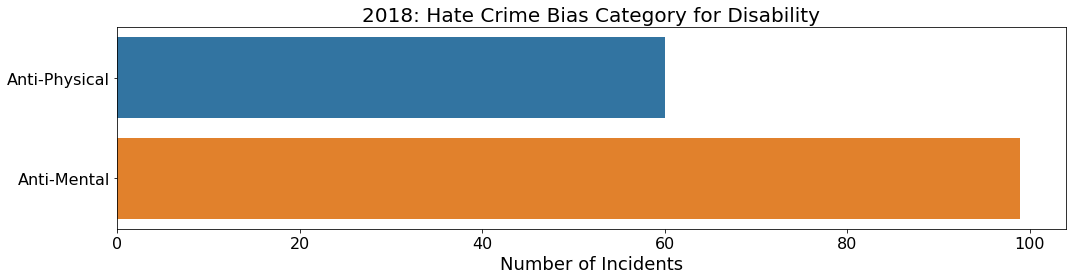

In [49]:
# Plot Bar Graph for Each Category
catdis_x=[]
for each_dis in fbiCat2018['Bias motivation'][34:36]:
    catdis_x.append(each_dis)

catdis_y=[]
for each_disy in fbiCat2018['Incidents'][34:36]:
    catdis_y.append(each_disy)

fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
catdis=sns.barplot(x = catdis_y, y = catdis_x, ax=ax, data=fbiCat2018)

ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

plt.title('2018: Hate Crime Bias Category for Disability', size= "20")
plt.ylabel('', size= "16")
plt.xlabel('Number of Incidents', size= "18")

fig.tight_layout()
plt.show() # Show plot

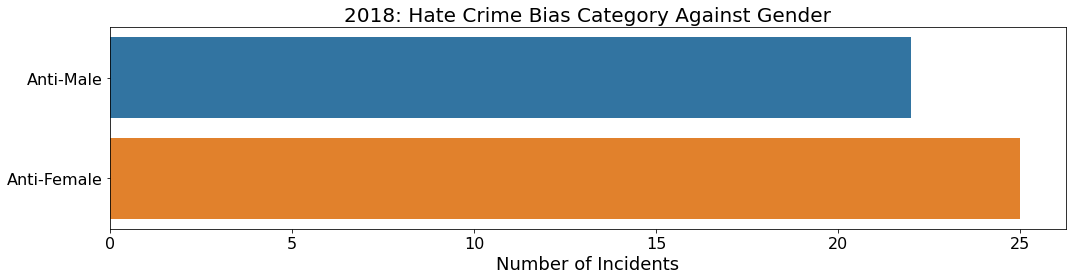

In [50]:
# Plot Bar Graph for Each Category
catgender_x=[]
for each_genderx in fbiCat2018['Bias motivation'][37:39]:
    catgender_x.append(each_genderx)

catgender_y=[]
for each_gendery in fbiCat2018['Incidents'][37:39]:
    catgender_y.append(each_gendery)

fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
catgender=sns.barplot(x = catgender_y, y = catgender_x, ax=ax, data=fbiCat2018)

ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

plt.title('2018: Hate Crime Bias Category Against Gender', size= "20")
plt.ylabel('', size= "16")
plt.xlabel('Number of Incidents', size= "18")

fig.tight_layout()
plt.show() # Show plot

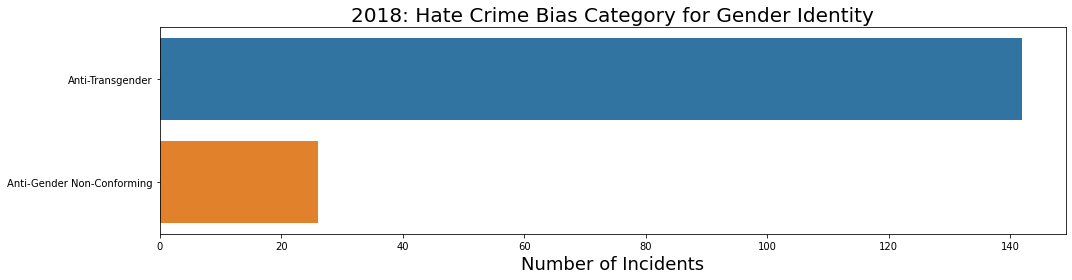

In [51]:
# Plot Bar Graph for Each Category
catgeni_x=[]
for each_genx in fbiCat2018['Bias motivation'][40:42]:
    catgeni_x.append(each_genx)

catgeni_y=[]
for each_geny in fbiCat2018['Incidents'][40:42]:
    catgeni_y.append(each_geny)

fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
catgeni=sns.barplot(x = catgeni_y, y = catgeni_x, ax=ax, data=fbiCat2018)   

plt.title('2018: Hate Crime Bias Category for Gender Identity', size= "20")
plt.ylabel('', size= "16")
plt.xlabel('Number of Incidents', size= "18")

fig.tight_layout()
plt.show() # Show plot

### 2018 Gini Index

The scatter plot below shows 2018 Gini index vs Hate Crime. The scatter plot shows that there is some kind of correlation between Gini index and the hate crime.

C:\Users\clair\Anaconda3\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


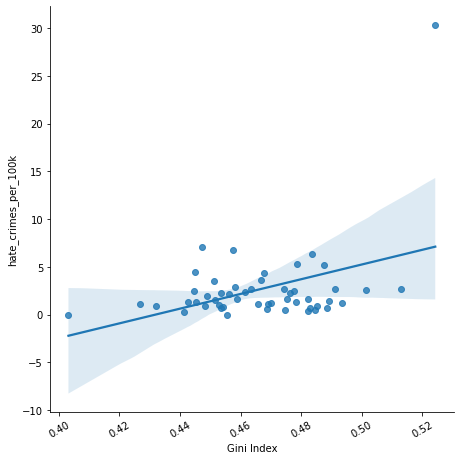

In [53]:
##scatter plot for how FBI hatecrime relate to gini index
grid = sns.lmplot('Gini Index','hate_crimes_per_100k', hate_crime_totals, size=6.5, palette="Blues_d",truncate=True)

# Rotate the labels on x-axis
grid.set_xticklabels(rotation=30)

plt.tight_layout()
plt.show()

# **Multiple Linear Regression Analysis** 

The goal of this section is to further our analysis and to determine any significant factor(s) of hate crime rates for different types of hate crimes. 

### **Race/Ethnicity/Ancestry**

To begin, we regressed all the census variables against the 'Race/Ethnicity/Ancestry' hate crime category. From the output, Gini Index was the only significant variable, so a reduced model was then created with just the one variable as the regressor. 

In [54]:
#run and fit the model
#must put variable names into patsy's quote Q due to spaces and characters in the column names
modREA = smf.ols(formula = 'Q("Race/Ethnicity/Ancestry") ~ School_system_expend_by_pop + Q("Median Household Income") + Q("Share Population White") + Q("Gini Index") + Q("Share HS Grad 18-24")', data=hate_crime_totals)
modFitREA = modREA.fit()

#display summary of model
print(modFitREA.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Q("Race/Ethnicity/Ancestry")   R-squared:                       0.220
Model:                                      OLS   Adj. R-squared:                  0.133
Method:                           Least Squares   F-statistic:                     2.539
Date:                          Mon, 27 Apr 2020   Prob (F-statistic):             0.0416
Time:                                  20:05:08   Log-Likelihood:                -306.38
No. Observations:                            51   AIC:                             624.8
Df Residuals:                                45   BIC:                             636.3
Df Model:                                     5                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------

Running the regression of the reduced model, we can see that Gini Index is significant. The adjusted R-squared value of the model is 0.112 which indicates that the correlation between the regressor and the response is positive, but very weak. 

In [55]:
#run and fit reduced model
#must put variable names into patsy's quote Q due to spaces and characters in the column names
redModREA = smf.ols(formula = 'Q("Race/Ethnicity/Ancestry") ~ Q("Gini Index")', data=hate_crime_totals)
redModFitREA = redModREA.fit()

#display summary of model
print(redModFitREA.summary())

-781.7666891230836
                                 OLS Regression Results                                 
Dep. Variable:     Q("Race/Ethnicity/Ancestry")   R-squared:                       0.129
Model:                                      OLS   Adj. R-squared:                  0.112
Method:                           Least Squares   F-statistic:                     7.276
Date:                          Mon, 27 Apr 2020   Prob (F-statistic):            0.00956
Time:                                  20:05:10   Log-Likelihood:                -309.18
No. Observations:                            51   AIC:                             622.4
Df Residuals:                                49   BIC:                             626.2
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------

The scatterplot below plots the fitted values from the regression, as well as the true dependent variable, Race/Ethnicity/Ancestry, against the independent variable, Gini Index. This type of plot also includes prediction confidence intervals. From the scatterplot, we can see the positive relationship between Gini Index and the number of Race/Ethnicity/Ancestry related hate crimes. 

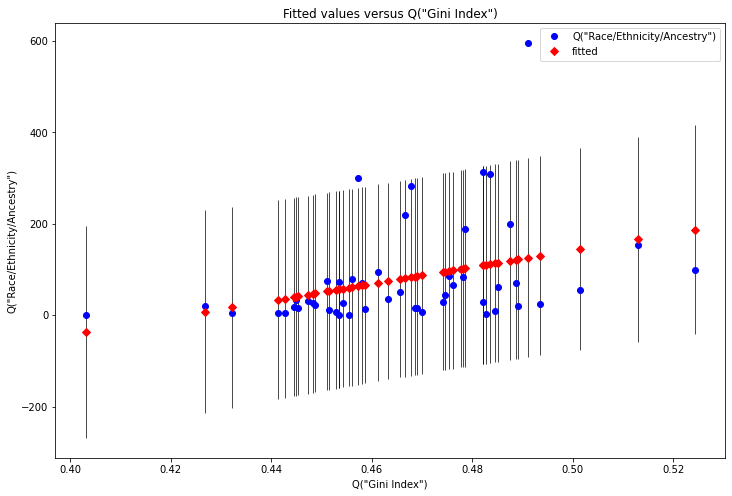

In [56]:
#plot_fit is a fit plot that plots the fitted values against an independent variable
#plot includes prediction confidence intervals and optionally plots the true dependent variable
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(redModFitREA, 'Q("Gini Index")', ax=ax)

In [57]:
#Now going to add the predicted values and residuals to the table
hate_crime_totals['PredictedREA'] = redModFitREA.predict(hate_crime_totals['Gini Index'])
hate_crime_totals['ResidualsREA'] = hate_crime_totals['Race/Ethnicity/Ancestry'] - hate_crime_totals['PredictedREA']

The residuals are used to assess the OLS assumptions of the model. The regression plot indicates that the constant variance assumption is violated, so a transformation would be required. Since we are exploring the base relationships of these variables, further transformations are not done in this program, but would be required if one wants to use the model for predictions.

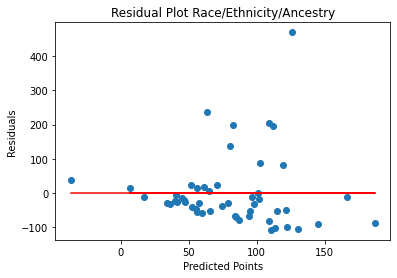

In [58]:
#Now can make residual plot

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(hate_crime_totals['PredictedREA'],hate_crime_totals['ResidualsREA'])
ax.plot(hate_crime_totals['PredictedREA'],hate_crime_totals['PredictedREA']*0, 'r-')
ax.set_title("Residual Plot Race/Ethnicity/Ancestry")
ax.set_xlabel("Predicted Points")
ax.set_ylabel("Residuals")

plt.show()

### **Religion**

Next, we regressed all the census variables against the 'Religion' hate crime category. From the output, Gini Index was the only significant variables, so a reduced model was then created with just the one variable as the regressor.

In [59]:
#run and fit the model
#must put variable names into patsy's quote Q due to spaces and characters in the column names
modReligion = smf.ols(formula = 'Religion ~ School_system_expend_by_pop + Q("Median Household Income") + Q("Share Population White") + Q("Gini Index") + Q("Share HS Grad 18-24")', data=hate_crime_totals)
modFitReligion = modReligion.fit()

#display summary of model
print(modFitReligion.summary())

                            OLS Regression Results                            
Dep. Variable:               Religion   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     4.453
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00222
Time:                        20:05:19   Log-Likelihood:                -265.60
No. Observations:                  51   AIC:                             543.2
Df Residuals:                      45   BIC:                             554.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Running the regression of the further reduced model, we can see that Gini Index is still significant. The adjusted R-squared value of the model is 0.171 which indicates that the correlation between the regressor and the response is positive, but very weak.

In [60]:
#run and fit the reduced model 2
#must put variable names into patsy's quote Q due to spaces and characters in the column names
redModReligion2 = smf.ols(formula = 'Religion ~ Q("Gini Index")', data=hate_crime_totals)
redModFitReligion2 = redModReligion2.fit()

#display summary of model
print(redModFitReligion2.summary())

                            OLS Regression Results                            
Dep. Variable:               Religion   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     11.30
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00151
Time:                        20:05:21   Log-Likelihood:                -270.56
No. Observations:                  51   AIC:                             545.1
Df Residuals:                      49   BIC:                             549.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -475.3660    149.980     

The scatterplot below plots the fitted values from the regression, as well as the true dependent variable, Religion, against the independent variable, Gini Index. This type of plot also includes prediction confidence intervals. From the scatterplot, we can see the positive relationship between Gini Index and the number of Religion related hate crimes.

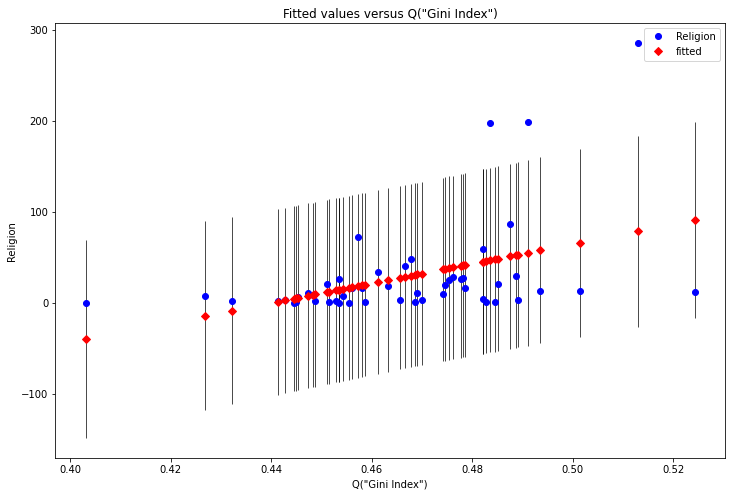

In [61]:
#plot_fit is a fit plot that plots the fitted values against an independent variable
#plot includes prediction confidence intervals and optionally plots the true dependent variable
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(redModFitReligion2, 'Q("Gini Index")', ax=ax)

In [62]:
#Now going to add the predicted values and residuals to the table
hate_crime_totals['PredictedReligion'] = redModFitReligion2.predict(hate_crime_totals['Gini Index'])
hate_crime_totals['ResidualsReligion'] = hate_crime_totals['Religion'] - hate_crime_totals['PredictedReligion']

The residuals are used to assess the OLS assumptions of the model. The regression plot indicates that the constant variance assumption is violated, so a transformation would be required. Since we are exploring the base relationships of these variables, further transformations are not done in this program, but would be required if one wants to use the model for predictions.

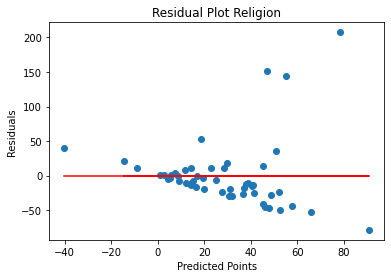

In [63]:
#Now can make residual plot

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(hate_crime_totals['PredictedReligion'],hate_crime_totals['ResidualsReligion'])
ax.plot(hate_crime_totals['PredictedReligion'],hate_crime_totals['PredictedReligion']*0, 'r-')
ax.set_title("Residual Plot Religion")
ax.set_xlabel("Predicted Points")
ax.set_ylabel("Residuals")

plt.show()

### **Sexual orientation, Gender, Gender Identity**

Then, we regressed all the census variables against the 'Sex/Gender' (Sexual orientation, Gender, and Gender Identity) hate crime category. From the output, Gini Index and Median Household Income were the only significant variables, so a reduced model was then created with just those two variable as the regressors.

In [64]:
#run and fit the model
#must put variable names into patsy's quote Q due to spaces and characters in the column names
modSG = smf.ols(formula = 'Q("Sex/Gender") ~ School_system_expend_by_pop + Q("Median Household Income") + Q("Share Population White") + Q("Gini Index") + Q("Share HS Grad 18-24")', data=hate_crime_totals)
modFitSG = modSG.fit()

#display summary of model
print(modFitSG.summary())

                            OLS Regression Results                            
Dep. Variable:        Q("Sex/Gender")   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     4.304
Date:                Mon, 27 Apr 2020   Prob (F-statistic):            0.00277
Time:                        20:05:30   Log-Likelihood:                -255.86
No. Observations:                  51   AIC:                             523.7
Df Residuals:                      45   BIC:                             535.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

From the output of the reduced model below, both Gini Index and Median Household Income were significant. The adjusted R-squared value of the model is 0.269 which indicates that the correlation between the regressor and the response is positive, but weak.

In [65]:
#run and fit the model
#must put variable names into patsy's quote Q due to spaces and characters in the column names
redModSG = smf.ols(formula = 'Q("Sex/Gender") ~ Q("Gini Index") + Q("Median Household Income")', data=hate_crime_totals)
redModFitSG = redModSG.fit()

#display summary of model
print(redModFitSG.summary())

                            OLS Regression Results                            
Dep. Variable:        Q("Sex/Gender")   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     10.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           0.000206
Time:                        20:05:33   Log-Likelihood:                -256.81
No. Observations:                  51   AIC:                             519.6
Df Residuals:                      48   BIC:                             525.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

The scatterplot below plots the fitted values from the regression, as well as the true dependent variable, Sex/Gender, against the independent variables, Gini Index and Median Household Income. From the scatterplot, we can see the positive relationship between the regressors and the number of Sex and Gender/Gender Identity related hate crimes. We can also see that Gini Index having a greater relationship to the number of Sex and Gender/Gender Identity related hate crimes below. 

<IPython.core.display.Javascript object>


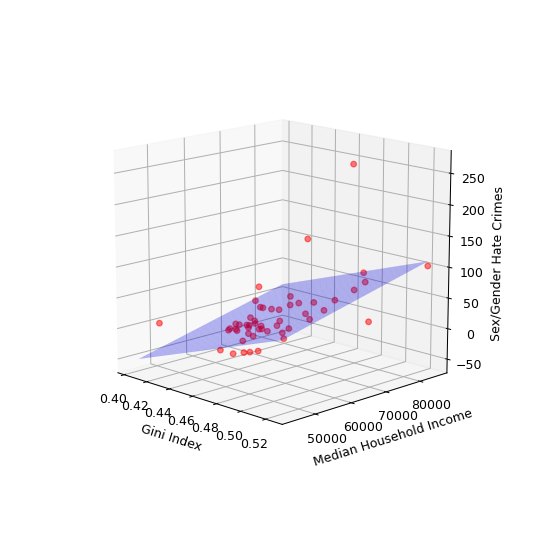

In [74]:
get_ipython().run_line_magic('matplotlib', 'notebook') #may have to run twice for interacivity to load correctly

#Prepare the data for Visualization
x_surf, y_surf = np.meshgrid(np.linspace(hate_crime_totals['Gini Index'].min(),hate_crime_totals['Gini Index'].max(), 100), np.linspace(hate_crime_totals['Median Household Income'].min(),hate_crime_totals['Median Household Income'].max(), 100))
onlyX = pd.DataFrame({'Gini Index': x_surf.ravel(), 'Median Household Income': y_surf.ravel()})
fittedY = redModFitSG.predict(exog=onlyX)

#Convert the predicted result in an array
fittedY = np.array(fittedY)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
ax.scatter(hate_crime_totals['Gini Index'],hate_crime_totals['Median Household Income'],hate_crime_totals['Sex/Gender'],c='red', marker='o', alpha=0.5)
ax.plot_surface(x_surf,y_surf,fittedY.reshape(x_surf.shape), color='blue', alpha=0.3)
ax.set_xlabel('Gini Index')
ax.set_ylabel('Median Household Income')
ax.set_zlabel('Sex/Gender Hate Crimes')
plt.show()

In [68]:
#End interactive 3d plots 
get_ipython().run_line_magic('matplotlib', 'inline')

In [69]:
#Now going to add the predicted values and residuals to the table
hate_crime_totals['PredictedSG'] = redModFitSG.predict(hate_crime_totals[['Gini Index','Median Household Income']])
hate_crime_totals['ResidualsSG'] = hate_crime_totals['Sex/Gender'] - hate_crime_totals['PredictedSG']

The residuals are used to assess the OLS assumptions of the model. The regression plot indicates that the constant variance is violated, so a transformation would be required. Since we are exploring the base relationships of these variables, further transformations are not done in this program, but would be required if one wants to use the model for predictions.

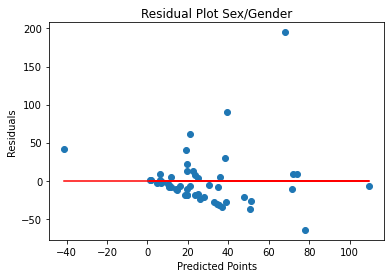

In [70]:
#Now can make residual plot

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(hate_crime_totals['PredictedSG'],hate_crime_totals['ResidualsSG'])
ax.plot(hate_crime_totals['PredictedSG'],hate_crime_totals['PredictedSG']*0, 'r-')
ax.set_title("Residual Plot Sex/Gender")
ax.set_xlabel("Predicted Points")
ax.set_ylabel("Residuals")

plt.show()

### **Disability**

Finally, we regressed all the census variables against the 'Disability' hate crime category. From the output, there are no significant variables, so further investigation would be required into introducing other variables or any possible multicollinearity between the current variables. One years worth of data on Disability hate crimes may also not be enough to draw an adequate conclusion.

In [71]:
#run and fit the model
#must put variable names into patsy's quote Q due to spaces and characters in the column names
modDisability = smf.ols(formula = 'Disability ~ School_system_expend_by_pop + Q("Median Household Income") + Q("Share Population White") + Q("Gini Index") + Q("Share HS Grad 18-24")', data=hate_crime_totals)
modFitDisability = modDisability.fit()

#display summary of model
print(modFitDisability.summary())

                            OLS Regression Results                            
Dep. Variable:             Disability   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                    0.2896
Date:                Mon, 27 Apr 2020   Prob (F-statistic):              0.916
Time:                        20:06:33   Log-Likelihood:                -160.46
No. Observations:                  51   AIC:                             332.9
Df Residuals:                      45   BIC:                             344.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

The overall results of this multiple linear regression analysis show that a state's school Gini Index is the most significant factor in the hate crime levels reported by the FBI during 2018. This is consistent with our results from the analysis conducted with the 2010 to 2015 data set. However, this analysis only considers one year and the residual plots show that at least one transformation would be required on each regression model for any predictive capabilities. There is also the potential for different variables to include in future models that may better explain hate crime rates. 

The models may not be perfect, but all of the analysis (2010-2015 and 2018) shows that inequality levels prove to be a significant factor in hate crime levels. 

# Testing

In order to ensure that our system produces the correct results, we created sets of unittests that address major functions of the code. This includes loading data correctly either from github url or through webscraping, calculation of key descriptive statistics, and output of multiple linear regressions. We also tested for output of various plots and for results of data queries. 

There are a total of 36 unit tests.

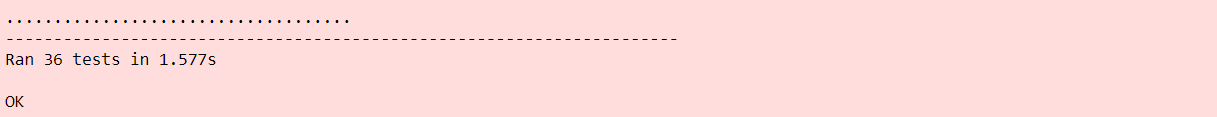

## Conclusion

In our original 2010 - 2015 dataset, it was determined that the Gini Index and Share Population with a High School degree proved to be the best predictors for determining the hate crime within a state. 

To look further into our research, our team decided to look at specific types of hate crime to see if further insight can be identified. Out of all of the identified groups, the group with the highest amount of hate crime incidents committed was Race/Ethnicity/Ancestry. We later determined that Gini Index was the only significant factor in relation to hate crimes committed based on premises of Race/Ethnicity/Ancestry. Furthermore, Gini Index was found to be a significant factor in explaining other types of hate crimes such as sexuality and religion. This is a powerful insight as it leads us to believe that with proper policies addressing inequality and with more efforts focused towards education on racism, disability, and differences in religious views we can change future generations of kids and thus lower crime rates, in general. 


## Beyond the Original Specifications


 
Our analysis of the 2010 to 2015 dataset and 2018 dataset were enriched through the use of multiple linear regression. To obtain our 2018 FBI hate crime data and 2018 US Census data, a web scraper was devised for each dataset. 


### 1. Webscrape


Please see webscrape section 

### 2. Take user input

In [72]:
input_state = input("Which state's data would you like to see?")
lower_input = input_state.lower()
stateOfInterest = lower_input.capitalize()
stateStat=data[data['state'].isin([stateOfInterest])]
stateStat

Which state's data would you like to see?Virginia


,state,median_household_income,share_unemployed_seasonal,share_population_in_metro_areas,share_population_with_high_school_degree,share_non_citizen,share_white_poverty,gini_index,share_non_white,share_voters_voted_trump,hate_crimes_per_100k_splc,avg_hatecrimes_per_100k_fbi,PredictedFBI,ResidualsFBI,PredictedSPLC,ResidualsSPLC
46,Virginia,66155,0.043,0.89,0.866,0.06,0.07,0.459,0.38,0.45,0.363249,1.724755,2.605774,-0.88102,0.333265,0.029984


## Improvements 


For more robust research, it would be beneficial to analyze more years. Also, it would be great to have professional expertise to give us insight into other potential variables that would be helpful in explaining hate crimes in the United States. 

Another improvement can be taking into account absent data. For our research, we replaced null values with the mean values of each group; however, for a more powerful result we can use a more sophisticated model that predicts the estimates of the null values. 

Lastly, we observed the presence of multicollinearity. For our future improvements, given more time, we can take a closer look at the relationships between variables and address the problem of multicollinearity.  Our theory is that School Expenditure has high correlation with Gini Index and Median Household Income thus making them insignificant in the model. 


## References

https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/

https://data.census.gov/

https://ucr.fbi.gov/hate-crime/